In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from matplotlib.path import Path
import ast
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx
from collections import Counter

In [ ]:
BEGIN = 3270 # da 2 raddoppio
ENDING = 4908
#FIRST_TIMESTAMP = 180 
#LAST_TIMESTAMP_before_WHITE = 4907 sarebbe da capire qual' é l ultimo minuto prima del bianco
#LAST_TIMESTAMP = 5189 sarebbe da capire qual' é l ultimo minuto prima del bianco


df = pd.read_csv(
        'data/reddit_trimmed.csv',
        engine="c",
        dtype={'timestamp':np.uint16,
          'user_id':np.uint32,
          'pixel_color':np.uint8,
          'x':np.uint16,
          'y':np.uint16,})

df = df[df['timestamp'] > BEGIN]
df = df[df['timestamp'] < ENDING]
ltot = len(df)

In [ ]:
user_dict= {}
row_counter = 0
ltot = len(df)

for row in df.itertuples():
    user = row.user_id
 
    if  user in user_dict:
        user_dict[user] = user_dict[user] + 1 
    else:
        user_dict[user] = 1
    row_counter = row_counter + 1
    
    if (row_counter % 5e6) == 0:
        print(f'{row_counter / ltot * 100:.2f}')

In [ ]:
THRES = 310
MIN_TILES = THRES
top_users = set()
for key in user_dict.keys():
    if user_dict[key] > THRES:
        top_users.add(key)
len(top_users)

In [ ]:
user_actions = {}
for i in list(range(20)):
    for j in list(range(20)):
        user_actions[i,j] = {}
max(user_actions.keys())

In [ ]:
row_counter = 0
for row in df.itertuples():
    user = row.user_id
    x = row.x
    y = row.y
    # new check 
    if user in top_users:
        i = x // 100
        j = y // 100 
        if user in user_actions[i,j]:
            user_actions[i,j][user] = user_actions[i,j][user] + 1 
        else:
            user_actions[i,j][user] = 1
                
                
    row_counter = row_counter + 1
    
    if (row_counter % 5e6) == 0:
        print(f'{row_counter / ltot * 100:.2f}')

In [ ]:
f = open('output/network_grid.csv', 'w')

counter = 0

for grid in user_actions.keys():

    for user_key in user_actions[grid].keys():
        f.write(str(grid[0]) + ',' + str(grid[1]) + ',' + str(user_key) + ',' + str(user_actions[grid][user_key]) + '\n')
        counter += 1
        
f.close()
counter

# Analysis

In [1]:
from networkx.algorithms import bipartite
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
G=nx.Graph()
fh=open('output/network_grid.csv','r')

for line in fh.readlines():
    s=line.strip().split(',')
    num = int(s[1]) + 100*(int(s[0]) - 1 )
    G.add_edge(str(num), int(s[2]), weight = int(s[3]))
    
fh.close()  

In [3]:
len(G.nodes)

139

In [46]:
counter = 0
for node in G.nodes:
    if isinstance(node, str):
        counter += 1
counter
print('abbiamo ',counter,' artworks e ', len(G.nodes) - counter, ' utenti' )

abbiamo  62  artworks e  72  utenti


In [4]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[134, 5]

In [5]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
G = nx.Graph(S[0])

### projected graph for arts

In [56]:
arts = nx.bipartite.sets(G)[0]
users = nx.bipartite.sets(G)[1]
len(arts), len(users)

(62, 72)

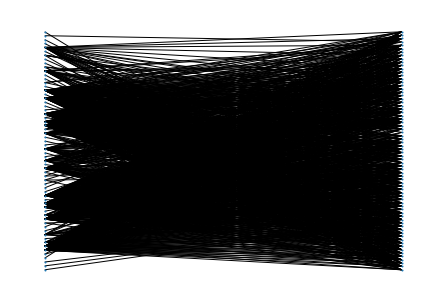

In [57]:
pos = nx.bipartite_layout(G, arts)
nx.draw(G,pos,node_size=1)
plt.savefig('plot/bipartite_net.png',dpi = 300,backend = 'cairo')

In [75]:
A = bipartite.projected_graph(G,arts, multigraph=False)
U = bipartite.projected_graph(G,users, multigraph=False)

In [77]:
len(A.edges), len(U.edges)

(793, 2477)

In [67]:
pos = nx.circular_layout(A)
#pos = nx.kamada_kawai_layout(A)
#pos = nx.spring_layout(A)

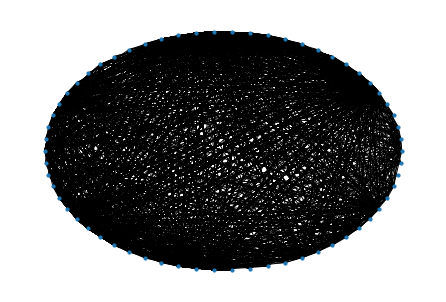

In [71]:
nx.draw(A,pos,node_size=10)
plt.savefig('plot/project_net_arts.png',dpi = 300,backend = 'cairo')

In [72]:
pos = nx.circular_layout(U)
#pos = nx.kamada_kawai_layout(U)
#pos = nx.spring_layout(U)

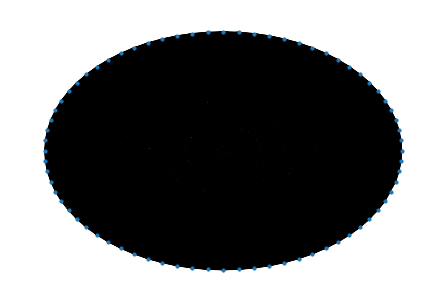

In [73]:
nx.draw(U,pos,node_size=10)
plt.savefig('plot/project_net_arts.png',dpi = 300,backend = 'cairo')

# analisi del network

### density

In [78]:
def density(G):
    return 2* G.number_of_edges()/(G.number_of_nodes() * (G.number_of_nodes() - 1))
density(A), density(U)

(0.41935483870967744, 0.9690923317683882)

### distribuzione di grado

Counter({25: 14, 18: 8, 55: 6, 5: 3, 15: 3, 12: 2, 16: 2, 6: 2, 26: 1, 33: 1, 14: 1, 52: 1, 23: 1, 11: 1, 53: 1, 59: 1, 9: 1, 19: 1, 48: 1, 35: 1, 28: 1, 34: 1, 32: 1, 13: 1, 54: 1, 10: 1, 36: 1, 21: 1, 22: 1, 2: 1})


(1.0, 10000.0, 1e-05, 1.0)

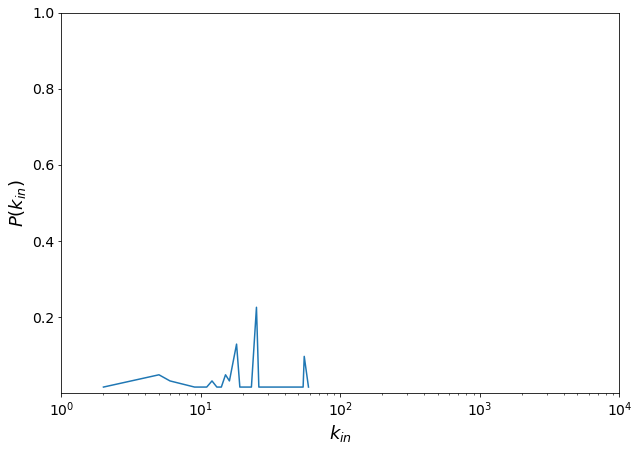

In [79]:
from collections import Counter 
import matplotlib.pyplot as plt

indeg=dict(A.degree()).values()
degin_distri=Counter(indeg)
print(degin_distri)


x=[]
y=[]

for i in sorted(degin_distri):   
    x.append(i)
    y.append(degin_distri[i]/len(A))

plt.figure(figsize=(10,7))    
plt.plot(x,y)

plt.xlabel('$k_{in}$', fontsize=18)
plt.ylabel('$P(k_{in})$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('linear')
plt.xscale('log')
plt.axis([1,10000,0.00001,1.0])

In [ ]:
### clustering

In [ ]:
### 